In [1]:
import numpy as np
import random
import os

In [2]:
seed = 10
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

<h3>1 Implementing and optimizing a Decision Tree</h3>

1.1 Implementation

Implement a decision tree using only the NumPy library. Train the decision tree on the provided training set (stl10 train features.npy for features and stl10 train labels.npy for labels), and then test its performance on the test set (stl10 test features.npy for features and stl10 test labels.npy for labels).

In [3]:
train_features = np.load('data/stl10_train_features.npy')
train_labels = np.load('data/stl10_train_labels.npy')
test_features = np.load('data/stl10_test_features.npy')
test_labels = np.load('data/stl10_test_labels.npy')

In [4]:
class Node:
    def __init__(self):
        self.depth = 0  # Depth of the current node in the tree
        self.is_terminal = False  # Flag indicating if the node is a leaf node
        self.column = None  # Index of the feature used for splitting at this node
        self.threshold = None  # Threshold value for splitting the feature
        self.left = None  # Reference to the left child node
        self.right = None  # Reference to the right child node
        self.probas = None  # Class probabilities at this node

class DecisionTreeClassifier:
    def __init__(self, max_depth=3, min_samples_leaf=1, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the decision tree
        self.min_samples_leaf = min_samples_leaf  # Minimum number of samples required to be at a leaf node
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split an internal node
        self.labels = None  # Unique classes in the target variable
        self.root = None  # Root node of the decision tree

    def nodeProbas(self, y):
        # Calculate class probabilities for a given node
        class_counts = np.bincount(y)
        return class_counts / len(y)

    def entropy(self, probas):
        # Calculate entropy given class probabilities
        return -np.sum(probas * np.log2(probas + 1e-10))  # Adding a small value to prevent log(0)

    def calcImpurity(self, y):
        # Calculate entropy (impurity) for a given set of labels
        probas = self.nodeProbas(y)
        return self.entropy(probas)

    def calcBestSplit(self, X, y):
        # Find the best feature and threshold for splitting
        best_split_col = None
        best_threshold = None
        best_info_gain = -np.inf
        impurity_before = self.calcImpurity(y)

        # Iterate over features and their unique values
        for col in range(X.shape[1]):
            for threshold in np.unique(X[:, col]):
                y_right = y[X[:, col] > threshold]
                y_left = y[X[:, col] <= threshold]

                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue

                impurity_right = self.calcImpurity(y_right)
                impurity_left = self.calcImpurity(y_left)

                # Calculate information gain
                info_gain = impurity_before - ((len(y_left) / len(y)) * impurity_left + (len(y_right) / len(y)) * impurity_right)

                if info_gain > best_info_gain:
                    best_split_col = col
                    best_threshold = threshold
                    best_info_gain = info_gain

        return best_split_col, best_threshold

    def build_tree(self, X, y, node):
        # Recursively build the decision tree
        if node.depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        split_col, threshold = self.calcBestSplit(X, y)

        if split_col is None:
            node.is_terminal = True

        if len(y[X[:, split_col] > threshold]) < self.min_samples_leaf or len(y[X[:, split_col] <= threshold]) < self.min_samples_leaf:
            node.is_terminal = True
            return

        node.column = split_col
        node.threshold = threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.nodeProbas(y[X[:, split_col] <= threshold])

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.nodeProbas(y[X[:, split_col] > threshold])

        self.build_tree(X[X[:, split_col] > threshold], y[X[:, split_col] > threshold], node.right)
        self.build_tree(X[X[:, split_col] <= threshold], y[X[:, split_col] <= threshold], node.left)

    def fit(self, X, y):
        # Fit the decision tree classifier to the training data
        self.labels = np.unique(y)
        self.root = Node()
        self.root.depth = 1
        self.root.probas = self.nodeProbas(y)
        self.build_tree(X, y, self.root)

    def predictSample(self, x, node):
        # Predict class probabilities for a single sample
        if node.is_terminal:
            return node.probas

        if x[node.column] > node.threshold:
            return self.predictSample(x, node.right)
        else:
            return self.predictSample(x, node.left)

    def predict(self, X):
        # Predict class labels for multiple samples
        predictions = []
        for x in X:
            pred = np.argmax(self.predictSample(x, self.root))
            predictions.append(pred)
        return np.asarray(predictions)

In [20]:
model = DecisionTreeClassifier(max_depth = 2, min_samples_leaf=1, min_samples_split=1)
model.fit(train_features, train_labels)
prediction = model.predict(test_features)
accuracy = np.mean(prediction == test_labels)
print("Test Set Accuracy:", accuracy)

Test Set Accuracy: 0.199875


1.2 Optimization of Hyperparameters

Optimize the hyperparameters of the decision tree, such as tree depth. Try to achieve a test set accuracy of 85% or more. Experiment with different values for each parameter and comment on the impact of variation in hyperparameters in the README.txt file (please limit your response to max 3-5 sentences).

In [11]:
best_accuracy = 0
best_params = {}

max_depth_values = [5, 7, 10, 13]
min_samples_leaf_values = [1, 2, 5, 7]
min_samples_split_values = [2, 4, 7, 10]

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        for min_samples_split in min_samples_split_values:
            model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
            model.fit(train_features, train_labels)

            y_pred = model.predict(test_features)
            
            accuracy = np.mean(y_pred == test_labels)
            
            print(accuracy)
            print({'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split})
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

print("Best Parameters:", best_params)
print("Test Accuracy:", best_accuracy)  

0.826625
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.826625
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.826625
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7}
0.826625
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.826625
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.826625
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.826625
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7}
0.826625
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.826625
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.826625
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4}
0.826625
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 7}
0.826625
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.826625
{'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
0.826625
{'max_depth': 5, 'min_samples_leaf': 7,

In [9]:
print("Best Parameters:", best_params)
print("Test Accuracy:", best_accuracy) 

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Test Accuracy: 0.868125


<h3>2 Implementing and optimizing a Random Forest</h3>

2.1 Implementation

Implement a random forest using your implemented decision tree (using only the NumPy library). Train the random forest on the training set and then test its performance on the test set. Use the information gain criterion as specified in the lecture.

In [12]:
class RandomForestClassifier:
    def __init__(self, n_trees=5, max_depth=3, min_samples_leaf=1, min_samples_split=2):
        self.n_trees = n_trees  # Number of decision trees in the forest
        self.max_depth = max_depth  # Maximum depth of each decision tree
        self.min_samples_leaf = min_samples_leaf  # Minimum number of samples required to be at a leaf node
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split an internal node
        self.trees = []  # List to store individual decision trees

    def fit(self, X, y):
        for _ in range(self.n_trees):
            # Randomly sample
            sample = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_sample = X[sample]
            y_sample = y[sample]
            
            # Train a decision tree on the sample
            tree = DecisionTreeClassifier(max_depth=self.max_depth, 
                                          min_samples_leaf=self.min_samples_leaf, 
                                          min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            
            # Add the trained tree to the list of trees
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions for each tree and aggregate the results
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
            
        # Use majority voting to get the final prediction
        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)

In [13]:
forest_model = RandomForestClassifier(n_trees=3, max_depth=3, min_samples_leaf=5, min_samples_split=2)
forest_model.fit(train_features, train_labels)

predictions = forest_model.predict(test_features)

accuracy = np.mean(predictions == test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.387


In [16]:
accuracy_list = []
# best_params = {max_depth: 10, min_samples_leaf: 5, min_samples_split: 2}

max_depth_values = [5, 7, 10, 13, 15, 18, 20, 25, 30]

for max_depth in max_depth_values:
    model = RandomForestClassifier(n_trees=max_depth, max_depth=10, min_samples_leaf=5, min_samples_split=2)
    model.fit(train_features, train_labels)

    y_pred = model.predict(test_features)
    
    accuracy = np.mean(y_pred == test_labels)
    accuracy_list.append(accuracy)
    
    print(accuracy, max_depth)

0.897375 5
0.8995 7
0.907 10
0.90725 13
0.90525 15
0.91025 18
0.90975 20
0.910125 25
0.9095 30


In [17]:
print("Best accuracy: {} with max_depth : {}".format(max(accuracy_list), max_depth_values[np.argmax(accuracy_list)]))

Best accuracy: 0.91025 with max_depth : 18


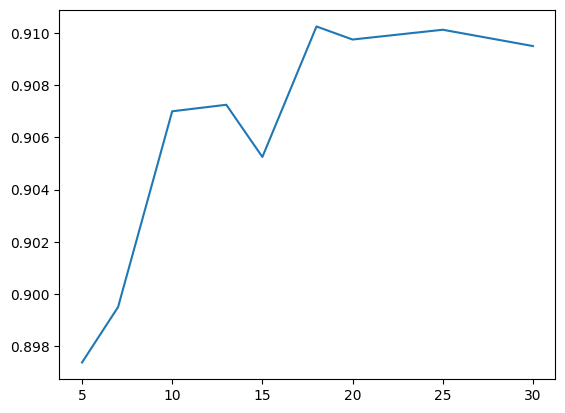

In [19]:
import matplotlib.pyplot as plt

plt.plot(max_depth_values, accuracy_list)